In [2]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np
import cpi

In [3]:
# Check that the CSV was read properly
movie_list = pd.read_csv("movies.csv")
movie_list.head()

,Title
0,The Shawshank Redemption
1,The Godfather
2,The Dark Knight
3,The Godfather Part II
4,12 Angry Men


In [4]:
# Add id column to the DataFrame
movie_list['id'] = ''
movie_list

,Title,id
0,The Shawshank Redemption,
1,The Godfather,
2,The Dark Knight,
3,The Godfather Part II,
4,12 Angry Men,
...,...,...
245,Jai Bhim,
246,Aladdin,
247,Gandhi,
248,The Help,


In [5]:
# TMDB API call
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/yIonSXf1jdNihhK8PssxO6KCIfz.jpg",
            "genre_ids": [
                878,
                18
            ],
            "id": 185,
            "original_language": "en",
            "original_title": "A Clockwork Orange",
            "overview": "In a near-future Britain, young Alexander DeLarge and his pals get their kicks beating and raping anyone they please. When not destroying the lives of others, Alex swoons to the music of Beethoven. The state, eager to crack down on juvenile crime, gives an incarcerated Alex the option to undergo an invasive procedure that'll rob him of all personal agency. In a time when conscience is a commodity, can Alex change his tune?",
            "popularity": 37.504,
            "poster_path": "/4sHeTAp65WrSSuc05nRBKddhBxO.jpg",
            "release_date": "1971-12-19",
            "title": "A Clockwork Orange",
            "video": false,
   

In [6]:
#response['results'][0]['id']

In [7]:
#OMDB API call
url = "http://www.omdbapi.com/?t="
#api_key = "&apikey=" + api_key
api_key_url = "&apikey=" + omdb_api_key
#print(api_key_url)
response = requests.get(url + "Jack Reacher" + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Actors": "Tom Cruise, Rosamund Pike, Richard Jenkins",
    "Awards": "1 win & 6 nominations",
    "BoxOffice": "$80,070,736",
    "Country": "United States",
    "DVD": "31 Dec 2014",
    "Director": "Christopher McQuarrie",
    "Genre": "Action, Mystery, Thriller",
    "Language": "English",
    "Metascore": "50",
    "Plot": "A homicide investigator digs deeper into a case involving a trained military sniper responsible for a mass shooting.",
    "Poster": "https://m.media-amazon.com/images/M/MV5BMTM1NjUxMDI3OV5BMl5BanBnXkFtZTcwNjg1ODM3OA@@._V1_SX300.jpg",
    "Production": "N/A",
    "Rated": "PG-13",
    "Ratings": [
        {
            "Source": "Internet Movie Database",
            "Value": "7.0/10"
        },
        {
            "Source": "Rotten Tomatoes",
            "Value": "63%"
        },
        {
            "Source": "Metacritic",
            "Value": "50/100"
        }
    ],
    "Released": "21 Dec 2012",
    "Response": "True",
    "Runtime": "130 min",
 

In [8]:
# Loop through the CSV's Title column to call said movie from the API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

In [9]:
# View the movies not found in the database
unfound_movies

['Gisaengchung', 'Oldeuboi', 'Capharnaüm']

In [10]:
#Print the DataFrame along with it's shape
print(movie_list.shape)
movie_list

(250, 2)


,Title,id
0,The Shawshank Redemption,278
1,The Godfather,238
2,The Dark Knight,155
3,The Godfather Part II,240
4,12 Angry Men,389
...,...,...
245,Jai Bhim,855400
246,Aladdin,420817
247,Gandhi,783
248,The Help,50014


In [11]:
# Export the City_Data into a csv
#movie_list.to_csv("movie_list.csv")

In [12]:
# movie_list_df = movie_list.loc[movie_list['id']=='NaN']
# movie_list_df

In [13]:
#Drop NaN rows
movie_list.dropna(how='any',inplace=True)

In [14]:
#Check size of Data Frame
movie_list.shape

(247, 2)

In [15]:
#Add columns name to the DataFrame
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,The Shawshank Redemption,278,,,,,,,,,
1,The Godfather,238,,,,,,,,,
2,The Dark Knight,155,,,,,,,,,
3,The Godfather Part II,240,,,,,,,,,
4,12 Angry Men,389,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
245,Jai Bhim,855400,,,,,,,,,
246,Aladdin,420817,,,,,,,,,
247,Gandhi,783,,,,,,,,,
248,The Help,50014,,,,,,,,,


In [16]:
# # Defining the path for each column value

#imdb_id = url_byid_response['imdb_id']
#release_date = url_byid_response['release_date']
#url_byid_response['revenue']
#url_byid_response['runtime']

# #extracting genre names from list
# for i in range(0,len(url_byid_response['genres'])):
#     print(url_byid_response['genres'][i]['name'])

# #extracting genre names from list
# for i in range(0,len(url_byid_response['production_countries'])):
#     print(url_byid_response['production_countries'][i]['name'])

#url_byid_response['popularity']
#url_byid_response['budget']

#url_byid_response['vote_average']


In [17]:
# #API call, search movie by ID
# for i in range(0,len(movie_list['Title']))
#     movie_id=movie_list['id'][i]
#     url_ById = "https://api.themoviedb.org/3/movie/"
#     build_url_ById=f"{url_ById}{movie_id}?api_key={api_key}"
#     url_byid_response=requests.get(build_url_ById).json()
#     #print(json.dumps(url_byid_response, indent=4, sort_keys=True))

In [18]:
# Loop through each movie's title for the API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        #extracting genre names from list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        #extracting production_countries names from list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [19]:
movie_list.head()

,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,The Shawshank Redemption,278,tt0111161,25000000,"Drama, Crime",28341469,142,94.45,1994-09-23,United States of America,8.704
1,The Godfather,238,tt0068646,6000000,"Drama, Crime",245066411,175,100.146,1972-03-14,United States of America,8.709
2,The Dark Knight,155,tt0468569,185000000,"Drama, Action, Crime, Thriller",1004558444,152,91.063,2008-07-16,"United Kingdom, United States of America",8.512
3,The Godfather Part II,240,tt0071562,13000000,"Drama, Crime",102600000,202,60.45,1974-12-20,United States of America,8.6
4,12 Angry Men,389,tt0050083,350000,Drama,1000000,97,39.315,1957-04-10,United States of America,8.5


In [20]:
movie_list.shape

(247, 11)

In [21]:
# Create a new "Year" column from the "release date" by making a new df converting to datetime
movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
movie_list["Year"] = movie_list["release_date"].dt.year
# movie_list.drop("release_date", axis=1, inplace=True)
movie_list=movie_list[["Title", "Year", "id", "imdb_id", "genres", "runtime", "budget", "revenue", "production_countries",
           "popularity", "tmdb_rating"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5
...,...,...,...,...,...,...,...,...,...,...,...
245,Jai Bhim,2021,855400,tt15097216,"Crime, Drama, Mystery",164,0,0,India,7.445,7.476
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2


In [22]:
# # Export the movie_df into a csv
# movie_list.to_csv("movie_df.csv")

In [23]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_budget

0      False
1      False
2      False
3      False
4      False
       ...  
245     True
246    False
247    False
248    False
249    False
Name: budget, Length: 247, dtype: bool

In [24]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# len(no_budget_df["budget"])
# no_budget_df

In [25]:
# View how many movies with no budget had no revenue either
# no_revenue = no_budget_df["revenue"]==0
# no_revenue.value_counts()

In [26]:
# Removing rows with zero budget movies
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5
...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2


In [27]:
# View if a movie had 0 budget or not (true/false)
movie_list["budget"].min()


133000

In [28]:
# View if a movie had 0 revenue or not (true/false)
no_revenue_1 = movie_list["revenue"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_revenue_1

0      False
1      False
2      False
3      False
4      False
       ...  
244    False
246    False
247    False
248    False
249    False
Name: revenue, Length: 223, dtype: bool

In [29]:
# Removing rows with zero revenue movies
movie_list=movie_list[~no_revenue_1]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5
...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2


In [30]:
# View if a movie had 0 revenue or not (true/false)
movie_list["revenue"].min()


96568

In [31]:
# Adjusting for inflation over the years
budget_past = 438656843
budget_year = 1991
budget_2023 = cpi.inflate(budget_past, budget_year)
round(budget_2023, 2)

942548593.16

In [32]:
movie_list['infl_adj_budget'] = ''
movie_list['infl_adj_revenue'] = ''
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/2093040814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = ''
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/2093040814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_revenue'] = ''


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704,,
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709,,
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512,,
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6,,
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246,,
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113,,
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544,,
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2,,


In [33]:
# Defining a function to calculate a running inflation adjusted value for a column in a dataframe
def inflate_column(data, column):
    #     Adjust for inflation the series of values in column of the dataframe data
    return data.apply(lambda x: cpi.inflate(x[column], x.Year), axis=1)

# adjust the production budget 
movie_list['budget'] = movie_list['budget'].astype(int)
movie_list['infl_adj_budget'] = inflate_column(movie_list, 'budget')
#adjust the worldwide gross profits
movie_list['infl_adj_revenue'] = inflate_column(movie_list, 'revenue').astype(float)

# calculate the real worldwide net profit
movie_list['real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/235147128.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['budget'] = movie_list['budget'].astype(int)
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/235147128.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = inflate_column(movie_list, 'budget')
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/235147128.py:10: SettingWithCopyWarning: 
A value is trying to be se

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704,4.936825e+07,5.596675e+07,6.598499e+06
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709,4.200789e+07,1.715787e+09,1.673779e+09
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512,2.514650e+08,1.365467e+09,1.114002e+09
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6,7.717069e+07,6.090548e+08,5.318841e+08
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5,3.645169e+06,1.041477e+07,6.769600e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246,1.045601e+07,4.706731e+07,3.661129e+07
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113,2.094833e+08,1.206880e+09,9.973968e+08
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544,6.671927e+07,2.357553e+08,1.690360e+08
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2,3.252604e+07,2.818565e+08,2.493305e+08


In [34]:
# Looking at a sampling of dataframe
print(movie_list.shape)
movie_list.sample(5)

(221, 14)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit
180,Ben-Hur,1959,665,tt0052618,"Action, Drama, History, Adventure",222,15000000,164000000,United States of America,32.68,7.869,1.508531e+08,1.649327e+09,1.498474e+09
19,Seven Samurai,1954,346,tt0047478,"Action, Drama",207,2000000,346300,Japan,34.291,8.452,2.175874e+07,3.767525e+06,-1.799121e+07
26,Interstellar,2014,157336,tt0816692,"Adventure, Drama, Science Fiction",169,165000000,701729206,"United Kingdom, United States of America",114.312,8.419,2.039744e+08,8.674834e+08,6.635091e+08
134,Everything Everywhere All at Once,2022,545611,tt6710474,"Action, Adventure, Science Fiction",140,25000000,139200000,United States of America,71.517,7.82,2.500000e+07,1.392000e+08,1.142000e+08
225,The Exorcist,1973,9552,tt0070047,Horror,122,12000000,441405644,United States of America,152.451,7.7,7.909595e+07,2.909450e+09,2.830354e+09


In [35]:
# #OMDB API call
# url = "http://www.omdbapi.com/?t="
# #api_key = "&apikey=" + api_key
# api_key_url = "&apikey=" + omdb_api_key
# #print(api_key_url)
# response = requests.get(url + "Jack Reacher" + api_key_url).json()
# print(json.dumps(response, indent=4, sort_keys=True))

In [36]:
for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_rating"] = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_votes"] = url_byid_response['imdbVotes']
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/2544307824.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[index, "imdb_rating"] = url_byid_response['imdbRating']
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/2544307824.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[index, "imdb_votes"] = url_byid_response['imdbVotes']


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704,4.936825e+07,5.596675e+07,6.598499e+06,9.3,"2,802,199"
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709,4.200789e+07,1.715787e+09,1.673779e+09,9.2,"1,954,449"
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512,2.514650e+08,1.365467e+09,1.114002e+09,9.0,"2,786,837"
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6,7.717069e+07,6.090548e+08,5.318841e+08,9.0,"1,327,261"
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5,3.645169e+06,1.041477e+07,6.769600e+06,9.0,"832,893"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246,1.045601e+07,4.706731e+07,3.661129e+07,8.1,"163,835"
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113,2.094833e+08,1.206880e+09,9.973968e+08,6.9,"282,377"
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544,6.671927e+07,2.357553e+08,1.690360e+08,8.0,"237,597"
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2,3.252604e+07,2.818565e+08,2.493305e+08,8.1,"480,538"


# Movie Data Analysis

In [37]:
# Define custom bin edges
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]

# Cut the data into custom intervals
movie_list['Decades'] = pd.cut(movie_list['Year'], bins=bin_edges)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/4147126356.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['Decades'] = pd.cut(movie_list['Year'], bins=bin_edges)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades
0,The Shawshank Redemption,1994,278,tt0111161,"Drama, Crime",142,25000000,28341469,United States of America,94.45,8.704,4.936825e+07,5.596675e+07,6.598499e+06,9.3,"2,802,199","(1990, 2000]"
1,The Godfather,1972,238,tt0068646,"Drama, Crime",175,6000000,245066411,United States of America,100.146,8.709,4.200789e+07,1.715787e+09,1.673779e+09,9.2,"1,954,449","(1970, 1980]"
2,The Dark Knight,2008,155,tt0468569,"Drama, Action, Crime, Thriller",152,185000000,1004558444,"United Kingdom, United States of America",91.063,8.512,2.514650e+08,1.365467e+09,1.114002e+09,9.0,"2,786,837","(2000, 2010]"
3,The Godfather Part II,1974,240,tt0071562,"Drama, Crime",202,13000000,102600000,United States of America,60.45,8.6,7.717069e+07,6.090548e+08,5.318841e+08,9.0,"1,327,261","(1970, 1980]"
4,12 Angry Men,1957,389,tt0050083,Drama,97,350000,1000000,United States of America,39.315,8.5,3.645169e+06,1.041477e+07,6.769600e+06,9.0,"832,893","(1950, 1960]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,The Handmaiden,2016,290098,tt4016934,"Thriller, Drama, Romance",145,8575000,38600000,South Korea,45.524,8.246,1.045601e+07,4.706731e+07,3.661129e+07,8.1,"163,835","(2010, 2020]"
246,Aladdin,2019,420817,tt6139732,"Adventure, Fantasy, Romance, Family",127,183000000,1054304000,United States of America,49.05,7.113,2.094833e+08,1.206880e+09,9.973968e+08,6.9,"282,377","(2010, 2020]"
247,Gandhi,1982,783,tt0083987,"Drama, History",191,22000000,77737889,"India, United Kingdom, United States of America",16.53,7.544,6.671927e+07,2.357553e+08,1.690360e+08,8.0,"237,597","(1980, 1990]"
248,The Help,2011,50014,tt1454029,Drama,146,25000000,216639112,"India, United Arab Emirates, United States of ...",51.982,8.2,3.252604e+07,2.818565e+08,2.493305e+08,8.1,"480,538","(2010, 2020]"


In [38]:
# Sorting movie_list df revenue column ascending=False
sorted_revenue_desc = movie_list.sort_values(by='infl_adj_revenue', ascending=False)
top_ten_df = sorted_revenue_desc.iloc[0:10, :] 
top_ten_df

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades
157,Gone with the Wind,1939,770,tt0031381,"Drama, War, Romance",238,4000000,402352579,United States of America,31.377,7.968,8.421727e+07,8.471259e+09,8.387041e+09,8.2,"327,145","(1930, 1940]"
27,Star Wars,1977,11,tt0076759,"Adventure, Action, Science Fiction",121,11000000,775398007,United States of America,73.786,8.204,5.312219e+07,3.744622e+09,3.691500e+09,8.6,"1,415,793","(1970, 1980]"
79,Avengers: Endgame,2019,299534,tt4154796,"Adventure, Science Fiction, Action",181,356000000,2800000000,United States of America,117.323,8.263,4.075194e+08,3.205209e+09,2.797689e+09,8.4,"1,217,571","(2010, 2020]"
225,The Exorcist,1973,9552,tt0070047,Horror,122,12000000,441405644,United States of America,152.451,7.7,7.909595e+07,2.909450e+09,2.830354e+09,8.1,"432,811","(1970, 1980]"
243,The Sound of Music,1965,15121,tt0059742,"Drama, Family, Music, Romance",174,8200000,286214286,United States of America,24.03,7.703,7.618321e+07,2.659112e+09,2.582929e+09,8.1,"249,969","(1960, 1970]"
205,Jaws,1975,578,tt0073195,"Horror, Thriller, Adventure",124,7000000,470653000,United States of America,37.829,7.66,3.807779e+07,2.560204e+09,2.522126e+09,8.1,"641,261","(1970, 1980]"
64,Avengers: Infinity War,2018,299536,tt4154756,"Adventure, Action, Science Fiction",149,300000000,2052415039,United States of America,165.451,8.254,3.496378e+08,2.392006e+09,2.042368e+09,8.4,"1,158,620","(2010, 2020]"
122,Spider-Man: No Way Home,2021,634649,tt10872600,"Action, Adventure, Science Fiction",148,200000000,1921847111,United States of America,178.162,7.988,2.160055e+08,2.075647e+09,1.859642e+09,8.2,"834,385","(2020, 2030]"
14,The Empire Strikes Back,1980,1891,tt0080684,"Adventure, Action, Science Fiction",124,18000000,538400000,United States of America,29.531,8.392,6.392949e+07,1.912202e+09,1.848273e+09,8.7,"1,344,359","(1970, 1980]"
35,The Lion King,2019,420818,tt6105098,"Adventure, Drama, Family",118,260000000,1663075401,"United Kingdom, United States of America",103.511,7.124,2.976265e+08,1.903751e+09,1.606125e+09,6.8,"259,841","(2010, 2020]"


<Axes: title={'center': 'Top 10 Grossing Movies (1922-2022)'}, xlabel='Movie Titles', ylabel='Movie Revenue'>

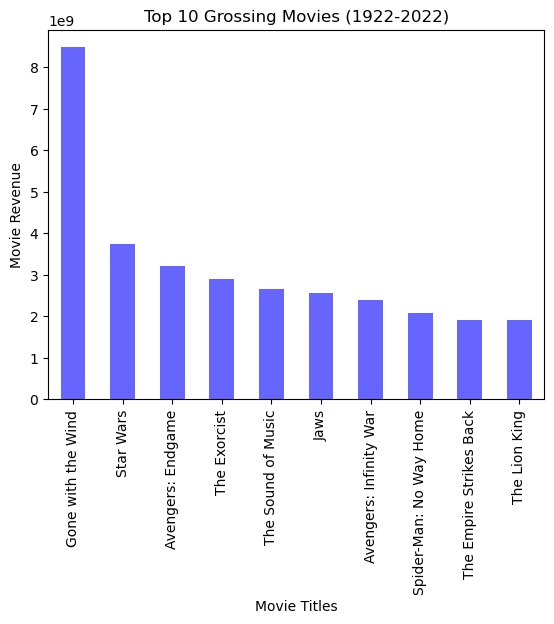

In [39]:
# Create a bar chart to display top 10 grossing movies

top_ten_df.plot("Title", "infl_adj_revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
                xlabel="Movie Titles", ylabel="Movie Revenue", legend='')


# ax=top_ten_df.plot("Title", "revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
#                 xlabel="Movie Titles", ylabel="Movie Revenue", legend='')
# ax.set_xticklabels(top_ten_df['Title'], rotation=45)
# plt.show()

<Axes: title={'center': 'Number of Movies per decade'}, xlabel='Decades', ylabel='Number of Movies'>

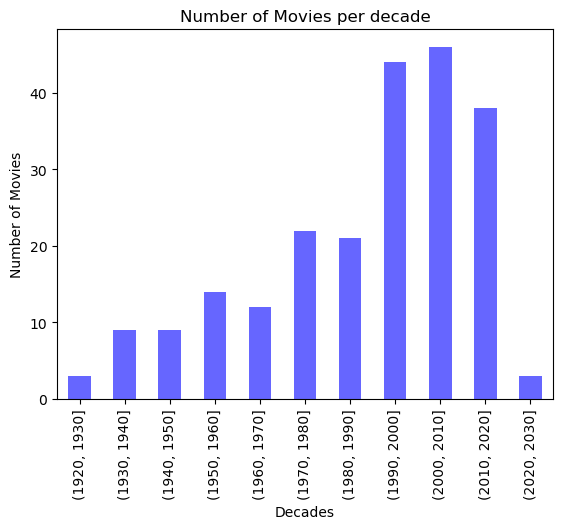

In [40]:
# Create a bar chart based upon the above data
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar', alpha=0.6, color='blue', title="Number of Movies per decade", xlabel="Decades", ylabel="Number of Movies")

## Pie Chart

In [43]:
# Minimum Budget
min_budget = movie_list['infl_adj_budget'].min()
# Average Budget
avg_budget = movie_list['infl_adj_budget'].mean()
# Maximum Budget
max_budget = movie_list['infl_adj_budget'].max()
diff = (max_budget-min_budget)/3
# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']
# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)
movie_list.sample(10)

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_69701/3799777054.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,infl_adj_budget,infl_adj_revenue,real_profit,imdb_rating,imdb_votes,Decades,Budget_Category
223,Ratatouille,2007,2062,tt0382932,"Animation, Comedy, Family, Fantasy",111,150000000,623726000,United States of America,102.717,7.809,2.117190e+08,8.803645e+08,6.686454e+08,8.1,"790,088","(2000, 2010]",Average Budget
235,Pirates of the Caribbean: The Curse of the Bla...,2003,22,tt0325980,"Adventure, Fantasy, Action",143,140000000,655011224,United States of America,97.598,7.795,2.226723e+08,1.041806e+09,8.191337e+08,8.1,"1,173,810","(2000, 2010]",Average Budget
128,The Kid,2000,4244,tt0219854,"Fantasy, Comedy, Family",104,65000000,110317580,United States of America,20.694,6.539,1.104679e+08,1.874854e+08,7.701752e+07,6.1,"43,636","(1990, 2000]",Low Budget
85,Singin' in the Rain,1952,872,tt0045152,"Comedy, Romance",103,2540800,7200000,United States of America,22.113,8.169,2.805954e+07,7.951381e+07,5.145427e+07,8.3,"253,693","(1950, 1960]",Low Budget
160,Inside Out,2015,150540,tt2096673,"Animation, Family, Adventure, Drama, Comedy",95,175000000,857611174,United States of America,90.455,7.922,2.160800e+08,1.058929e+09,8.428491e+08,8.1,"755,885","(2010, 2020]",Average Budget
29,Back to the Future,1985,105,tt0088763,"Adventure, Comedy, Science Fiction",116,19000000,381109762,United States of America,58.325,8.313,5.167700e+07,1.036558e+09,9.848813e+08,8.5,"1,266,466","(1980, 1990]",Low Budget
80,Once Upon a Time in America,1984,311,tt0087843,"Drama, Crime",229,30000000,5500000,"United States of America, Italy",38.041,8.428,8.450096e+07,1.549184e+07,-6.900912e+07,8.3,"367,587","(1980, 1990]",Low Budget
226,The Best Years of Our Lives,1946,887,tt0036868,"Drama, Romance, War",171,2100000,23650000,United States of America,14.155,7.8,3.151669e+07,3.549380e+08,3.234213e+08,8.1,"68,364","(1940, 1950]",Low Budget
146,The Treasure of the Sierra Madre,1948,3090,tt0040897,"Adventure, Drama, Western",126,3800000,4307000,United States of America,16.493,7.969,4.614477e+07,5.230146e+07,6.156684e+06,8.2,"129,842","(1940, 1950]",Low Budget
114,Metropolis,1927,19,tt0017136,"Drama, Science Fiction",149,1300000,650422,Germany,20.658,8.153,2.186503e+07,1.093961e+07,-1.092542e+07,8.3,"180,970","(1920, 1930]",Low Budget


  Budget_Category  count
0      Low Budget    189
1  Average Budget     27
2     High Budget      4


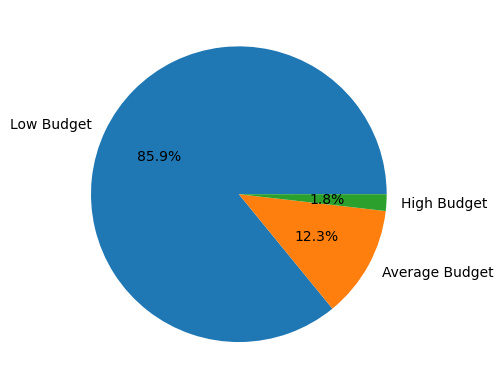

In [44]:
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.pie(y,autopct='%1.1f%%',labels=['Low Budget','Average Budget','High Budget'])
plt.show()

## Bar Plot

In [ ]:
#Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()
pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])
# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches
# Create a stacked bar plot
pivot_df.plot(kind='bar',width=1,color='orange', stacked=True)
# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Bar Plot of Budget Categories by Decades')
plt.legend( "Budget")
# Show the plot
plt.show()

## Scatter Plots with Linear Regression

In [ ]:
# Creating a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    plt.show()

In [ ]:
# Create a scatter plot for regression analysis

xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='Budget'
y_label='tmdb rating'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget'
y_label='imdb rating'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue'
y_label='imdb rating'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue'
y_label='Runtime(mins)'

lin_regress(xval, yval, x_label, y_label)

In [ ]:
# movie_list.loc["genres"].value_counts()

In [ ]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

In [ ]:
# Check how many Oscar nominations each film has
oscar_list["film"].value_counts()

In [ ]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head(2)

In [ ]:
# Check how many Golden Globe nominations each film has
gglobe_list["film"].value_counts()

In [ ]:
# # This will split a cell with multiple values back into a list
# newvar = movie_list.loc[9, "production_countries"].split(", ")
# newvar[2]

In [ ]:
# # Testing the Pandas "explode" function
# checkexplode = movie_list["genres"].explode('drama')
# checkexplode

In [ ]:
# Create a "contains value" function in Python to call on to pull specific genre or production country information
def contains_value(val, search_val):
    return search_val in val.split(', ')

In [ ]:
# crime_df = movie_list[movie_list['genres'].apply(lambda x: contains_value(x, 'Crime'))]
# drama_df = movie_list[movie_list['genres'].apply(lambda x: contains_value(x, 'Drama'))]


# # merge1_df = pd.merge(crime_df, drama_df, on=["Title", "Year", "id", "budget", "revenue", "popularity"])
# # merge1_df
# # merge1_df.groupby["Year"]
# # merge1_df

In [ ]:
# # Creating empty lists to split multiple-value columns' values into
# genre_list = []
# prod_country_list = []

# for index, row in movie_list.iterrows():
#     genre_list.append(movie_list.loc[index, "genres"].split(", "))
#     prod_country_list.append(movie_list.loc[index, "production_countries"])

# genre_df = pd.DataFrame(genre_list)
# prod_country_df = pd.DataFrame(prod_country_list)
# genre_df